## Import Necessary Libraries
This section imports all required libraries for data manipulation, model building, training, and evaluation, such as `pandas`, `torch`, `torch.nn`, `torch.optim`, `DataLoader`, and relevant `sklearn` modules.

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## Load and Preprocess Data
Load the preprocessed training dataset into a Pandas DataFrame and define categorical, continuous, target, and post-processing variables.

In [2]:
# Load the processed training data
df = pd.read_csv('data/processed/train.csv')

# Define categorical and continuous variables
cat_vars = ["merchant", "category", "gender", "city", "state", "job"]
cont_vars = ["amt", "lat", "long", "city_pop", "merch_lat", "merch_long"]
target = ["is_fraud"]
post_cont_vars = ["mean_monthly_amt", "amount_of_monthly_trans", "age", "mean_time_between_transactions_seconds"]

In [3]:
# Separate features and target
X = df[cat_vars + cont_vars + post_cont_vars].values
y = df[target].values

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=4000, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4000, shuffle=False)

## Define the Neural Network Model with Entity Embeddings
Define the `EntityEmbeddingNN` class, incorporating entity embeddings for categorical variables. The architecture includes embedding layers, dropout layers, and fully connected layers with ReLU activations and batch normalization.

In [4]:
# Define the neural network model with entity embeddings
class EntityEmbeddingNN(nn.Module):
    def __init__(self, embedding_sizes, n_cont, out_size, layers, p=0.5):
        super(EntityEmbeddingNN, self).__init__()
        
        self.embeddings = nn.ModuleList([nn.Embedding(categories, size) for categories, size in embedding_sizes])
        self.embedding_dropout = nn.Dropout(p)
        self.n_emb = sum(e.embedding_dim for e in self.embeddings)
        self.n_cont = n_cont

        self.layers = nn.Sequential(
            nn.Linear(self.n_emb + self.n_cont, layers[0]),
            nn.ReLU(),
            nn.BatchNorm1d(layers[0]),
            nn.Dropout(p),
            nn.Linear(layers[0], layers[1]),
            nn.ReLU(),
            nn.BatchNorm1d(layers[1]),
            nn.Dropout(p),
            nn.Linear(layers[1], out_size),
            nn.Sigmoid()
        )

    def forward(self, x_cat, x_cont):
        x = [e(x_cat[:, i]) for i, e in enumerate(self.embeddings)]
        x = torch.cat(x, 1)
        x = self.embedding_dropout(x)
        
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

In [5]:
# Define embedding sizes for categorical variables
categorical_column_sizes = [len(df[col].unique()) for col in cat_vars]
embedding_sizes = [(size, min(50, (size + 1) // 2)) for size in categorical_column_sizes]

# Number of continuous variables
n_cont = len(cont_vars + post_cont_vars)

# Initialize the model
model = EntityEmbeddingNN(embedding_sizes, n_cont, 1, [256, 128], p=0.3)

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


## Train the Model
Function to train the model using the training data, evaluating performance on the validation set after each epoch, and printing the training and validation loss and AUC scores.

In [6]:
# Function to train the model
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=25):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            x_cat = inputs[:, :len(cat_vars)].long()
            x_cont = inputs[:, len(cat_vars):]
            
            optimizer.zero_grad()
            outputs = model(x_cat, x_cont)
            loss = criterion(outputs, labels.view(-1, 1))  # Ensure labels shape is [batch_size, 1]
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        
        model.eval()
        val_running_loss = 0.0
        all_labels = []
        all_outputs = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                x_cat = inputs[:, :len(cat_vars)].long()
                x_cont = inputs[:, len(cat_vars):]
                
                outputs = model(x_cat, x_cont)
                loss = criterion(outputs, labels.view(-1, 1))  # Ensure labels shape is [batch_size, 1]
                val_running_loss += loss.item() * inputs.size(0)
                
                all_labels.extend(labels.view(-1).tolist())
                all_outputs.extend(outputs.view(-1).tolist())

        val_loss = val_running_loss / len(val_loader.dataset)
        val_auc = roc_auc_score(all_labels, all_outputs)
        
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Training Loss: {epoch_loss:.4f}, '
              f'Validation Loss: {val_loss:.4f}, '
              f'Validation AUC: {val_auc:.4f}')

In [7]:
# Train the model
train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10)

Epoch 1/10, Training Loss: 0.2442, Validation Loss: 0.0274, Validation AUC: 0.8728
Epoch 2/10, Training Loss: 0.0292, Validation Loss: 0.0196, Validation AUC: 0.9064
Epoch 3/10, Training Loss: 0.0238, Validation Loss: 0.0183, Validation AUC: 0.9206
Epoch 4/10, Training Loss: 0.0217, Validation Loss: 0.0172, Validation AUC: 0.9295
Epoch 5/10, Training Loss: 0.0201, Validation Loss: 0.0160, Validation AUC: 0.9358
Epoch 6/10, Training Loss: 0.0186, Validation Loss: 0.0144, Validation AUC: 0.9507
Epoch 7/10, Training Loss: 0.0173, Validation Loss: 0.0139, Validation AUC: 0.9548
Epoch 8/10, Training Loss: 0.0163, Validation Loss: 0.0136, Validation AUC: 0.9573
Epoch 9/10, Training Loss: 0.0157, Validation Loss: 0.0130, Validation AUC: 0.9628
Epoch 10/10, Training Loss: 0.0151, Validation Loss: 0.0126, Validation AUC: 0.9669


## Evaluate the Model
Function to evaluate the model on training and validation datasets, calculating loss, F1 score, and plotting a confusion matrix.

In [8]:
# Function to evaluate the model
def evaluate_model(model, criterion, data_loader, dataset_name="Validation"):
    model.eval()
    all_labels = []
    all_outputs = []
    all_predictions = []
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in data_loader:
            x_cat = inputs[:, :len(cat_vars)].long()
            x_cont = inputs[:, len(cat_vars):]
            
            outputs = model(x_cat, x_cont)
            loss = criterion(outputs, labels.view(-1, 1))
            running_loss += loss.item() * inputs.size(0)
            
            all_labels.extend(labels.view(-1).tolist())
            all_outputs.extend(outputs.view(-1).tolist())
            all_predictions.extend((outputs >= 0.5).float().view(-1).tolist())
    
    loss = running_loss / len(data_loader.dataset)
    f1 = f1_score(all_labels, all_predictions)
    cm = confusion_matrix(all_labels, all_predictions)
    
    print(f'{dataset_name} Loss: {loss:.4f}')
    print(f'{dataset_name} F1 Score: {f1:.4f}')
    
    # Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
    plt.title(f'{dataset_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

Training Loss: 0.0112
Training F1 Score: 0.7323


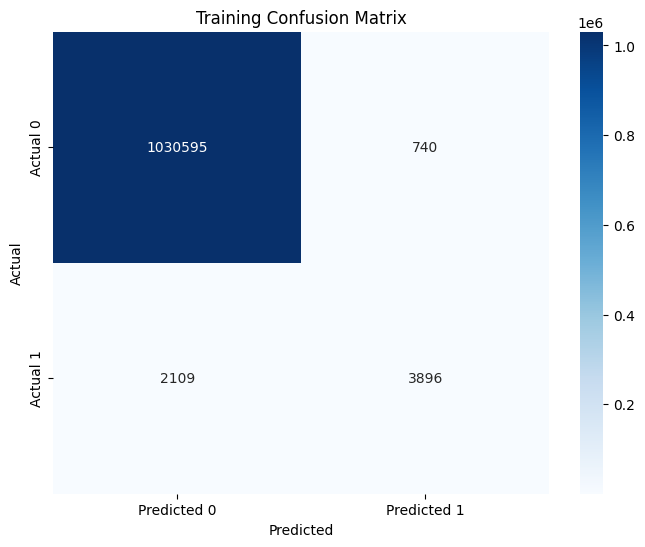

In [9]:
# Evaluate the model on the training set
evaluate_model(model, criterion, train_loader, dataset_name="Training")

Validation Loss: 0.0126
Validation F1 Score: 0.6997


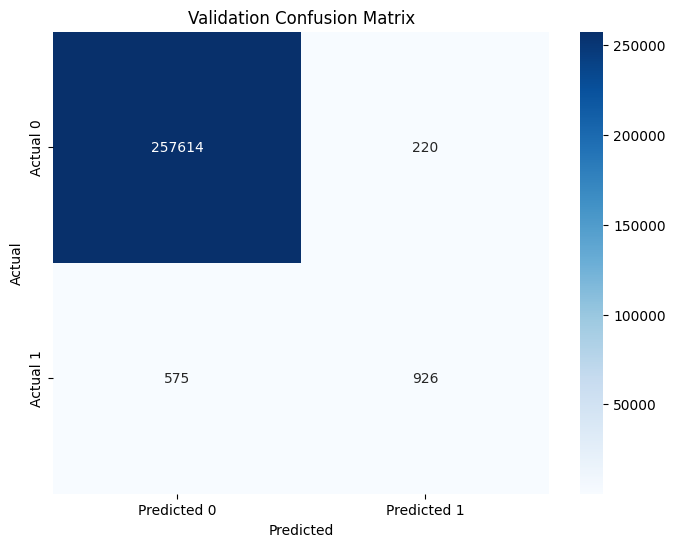

In [10]:
# Evaluate the model on the validation set
evaluate_model(model, criterion, val_loader, dataset_name="Validation")

## Save the Model and Additional Information
Save the trained model's state and parameters to a file for future use.

In [11]:
# Save the model and additional information
model_info = {
    'state_dict': model.state_dict(),
    'embedding_sizes': embedding_sizes,
    'n_cont': n_cont,
    'output_size': 1,
    'layers': [256, 128],
    'dropout_prob': 0.3
}

torch.save(model_info, 'trained_model_info.pth')